In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Задача
В этой работе вам предлагается решить задачу регрессии, а именно построить алгоритм, определяющий качество вина на основе физико-химических тестов:
 - fixed acidity
 - volatile acidity
 - citric acid
 - residual sugar
 - chlorides
 - free sulfur dioxide
 - total sulfur dioxide
 - density
 - pH
 - sulphates
 - alcohol 
 
Более подробно про признаки можно почитать [здесь](https://archive.ics.uci.edu/ml/datasets/wine+quality). Целевой признак записан в переменной *quality*.

В этой задаче для обучения будут использовать 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

# Решение

Загрузите набор данных *winequality-red.csv* с помощью `pandas` (скачать можно [здесь](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
# Читаем файл и просматриваем последние 5 строк
wine_df = pd.read_csv('data/winequality-red.csv', sep=';')
wine_df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения. Удалите из выборки все объекты с пропусками и дубликаты.
2. Выделите 70% выборки для обучения и дальнейшего анализа.
3. Проанализируйте признаки и по необходимости предобработайте их. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную (НЕ забудьте удалить ее из датасета, когда будете обучать модель).

In [3]:
# Проценты пропусков в каждой из колонок
cols_null_percent = wine_df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

# Пропуски отсутствуют

Series([], dtype: float64)

In [4]:
# Проверяем наличие дубликатов в колонках
duplicates = wine_df[wine_df.duplicated(keep = False)]
print(f'Число записей: {wine_df.shape[0]}')
print(f'Число найденных дубликатов: {duplicates.shape[0]}')
display(duplicates)

Число записей: 1599
Число найденных дубликатов: 460


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
11,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
22,7.9,0.430,0.21,1.6,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1567,7.2,0.695,0.13,2.0,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1579,6.2,0.560,0.09,1.7,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5
1581,6.2,0.560,0.09,1.7,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6


In [5]:
# Удаление дубликатов
wine_df = wine_df.drop_duplicates()
print(f'Результирующее число записей: {wine_df.shape[0]}')

Результирующее число записей: 1359


In [6]:
# Анализ типов данных
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


In [7]:
# Познакомимся с распредениями данных
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
# Функция для построения графиков распределения
def plot_distribution(df, column, color, row, axes):
    """
    Визуализация распределения и ящика с усами для указанного столбца.

    :param df: DataFrame, содержащий данные.
    :param column: Название столбца для визуализации.
    :param color: Цвет для графиков.
    :param row: Индекс строки в сетке графиков.
    :param axes: Массив осей для рисования графиков.
    """
    # Гистограмма
    histplot = sns.histplot(data=df, x=column, color=color, ax=axes[row][0])
    histplot.set_title(f'Распределение {column}')
    histplot.axvline(df[column].mean(), color='k', lw=2) # Среднее значение
    histplot.axvline(df[column].mean() + 3 * df[column].std(), color='k', ls='--', lw=2) # +3sigma
    histplot.axvline(df[column].mean() - 3 * df[column].std(), color='k', ls='--', lw=2) # -3sigma

    # Ящик с усами
    boxplot = sns.boxplot(data=df, x=column, color=color, ax=axes[row][1])
    boxplot.set_title(f'Распределение {column}')

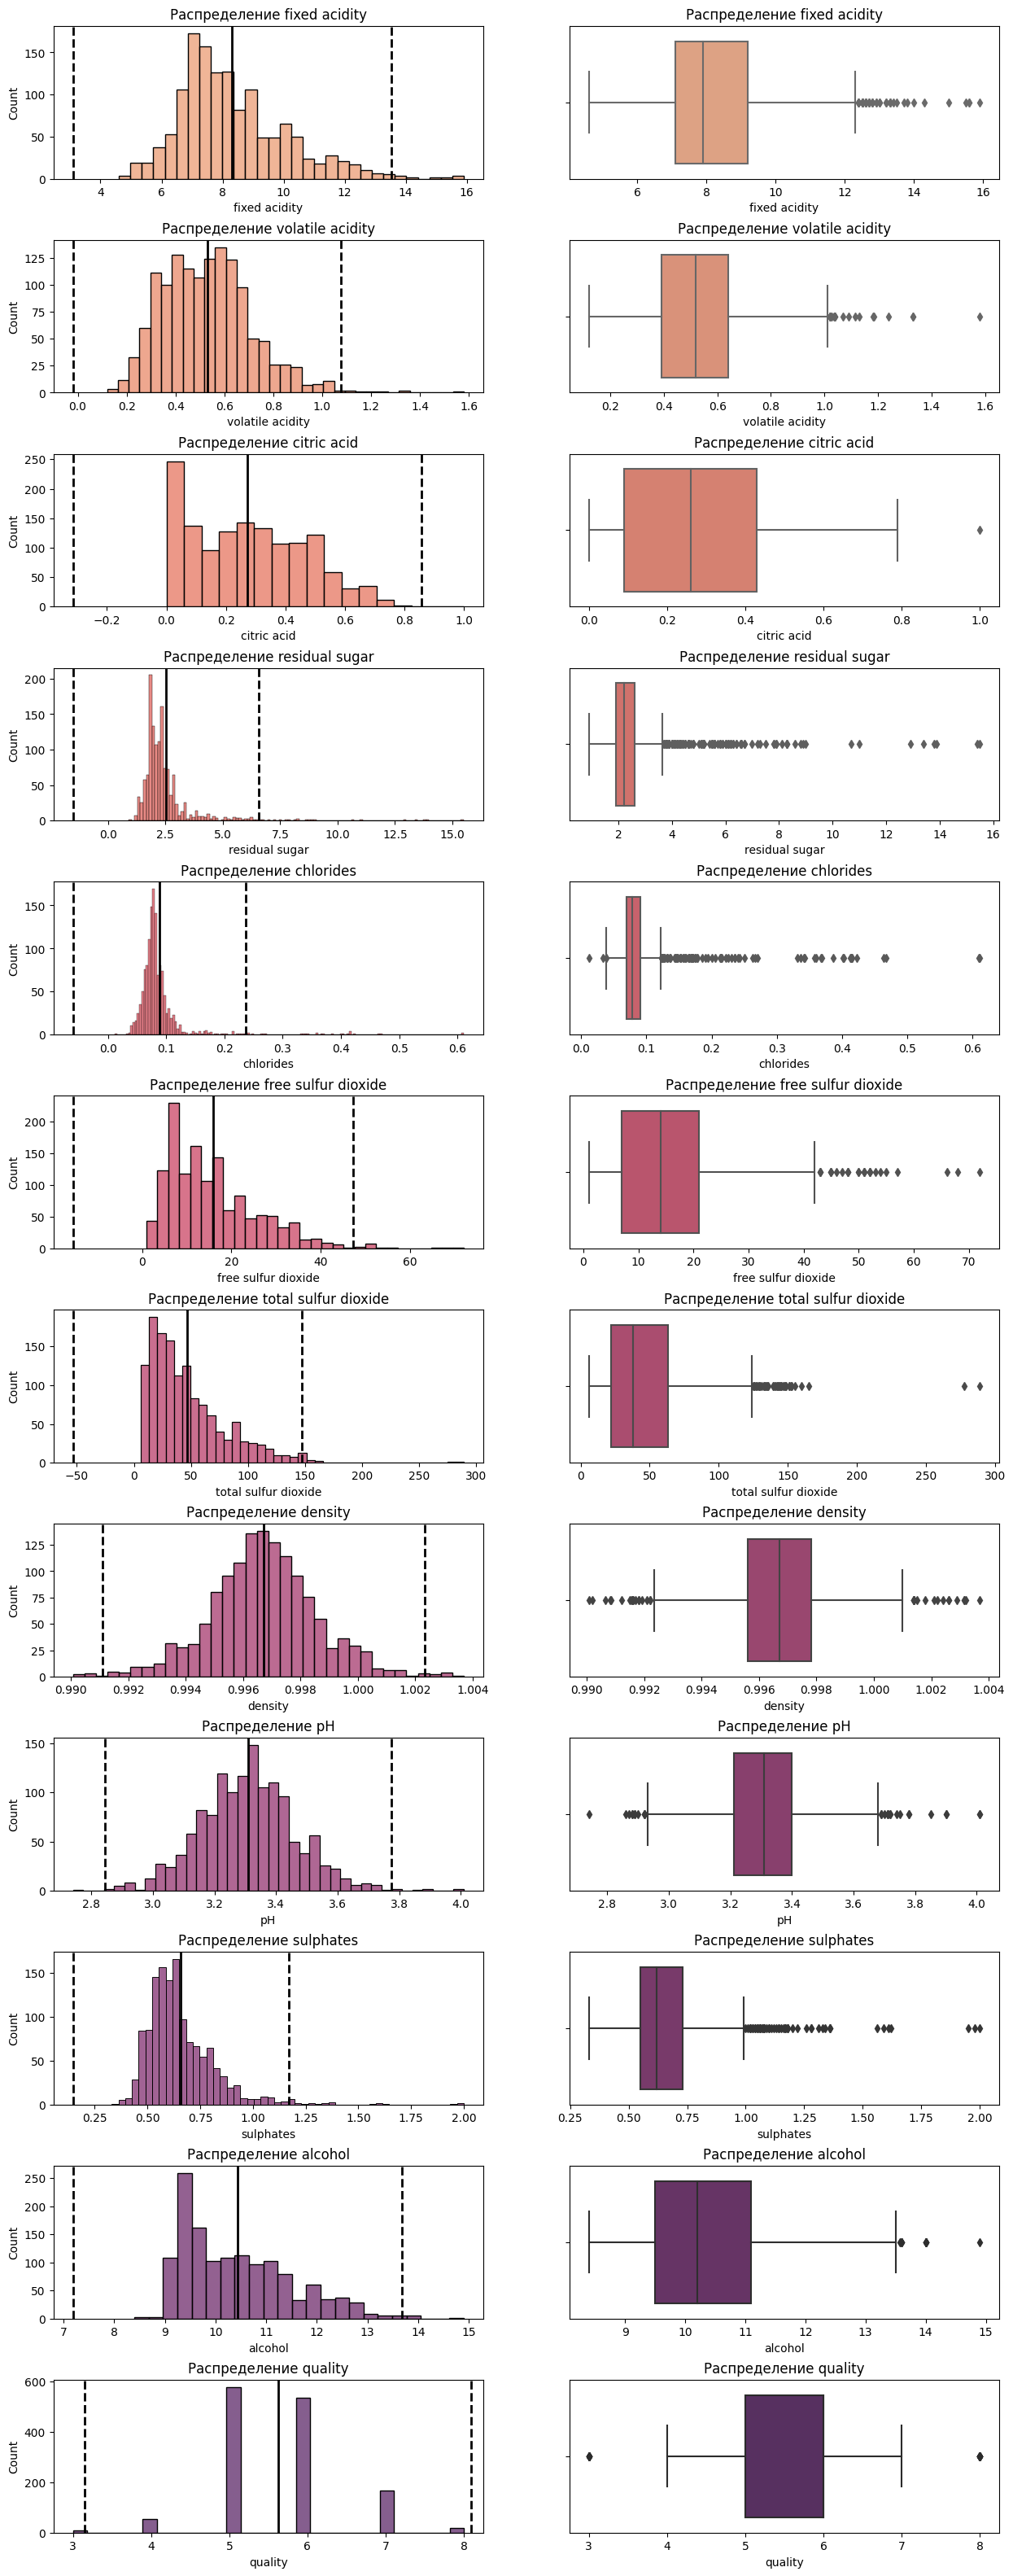

In [9]:
# Прописываем параметры для функции
colors = sns.color_palette('flare', n_colors=12)
fig, axes = plt.subplots(nrows=12, ncols=2, figsize=(15, 40))
plt.subplots_adjust(hspace=0.4)

columns_to_plot = wine_df.columns # колонки для которых выведем графики распределений

# используем цикл для формирования диаграмм
for i, column in enumerate(columns_to_plot):
    plot_distribution(wine_df, column, colors[i], i, axes)

- **Распределение fixed acidity**, данные право-скошенные, скорее распределены логнормально, на графике ящика с усами можно налюдать выбросы.
- **Распределение volatile acidity** имеет вид нормального распредления, присутствуют выбросы.
- **Распределение citric acid** не имеет выбросов
- **Распределения residual sugar и chlorites** имеют вид логнормального распределения, присутствует большое количество выбросов.
- **Распределения free sulfur dioxide и total sulfur dioxide** имеют вид логнормального распределения, присутсвует небольшое количество выбросов.
- **Распределения density и pH** имеют вид нормального распределения, присутсвует небольшое количество выбросов.
- **Распределения sulphates и alchole** имеют вид логнормального распределения, присутсвует небольшое количество выбросов.
- **Признак quality** является дискретной величиной, минимальное значение 3, максимальное 8, наиболее часто-встречающиеся значения 5 и 6.

> Для устранения выбросов будем использовать использовать метод z-отклонений, но так как некоторые распределения похожи на логнормальные, построим их в логарифмическом масштабе и исследуем их на выбросы.

In [10]:
# Функция для построения логарифмического распределения
def plot_log_distribution(df, column, ax, color, add_one=False):
    """
    Строит логарифмическое распределение для заданного столбца данных.

    :param df: DataFrame, содержащий данные.
    :param column: Название столбца для визуализации.
    :param ax: Объект matplotlib axis, на котором будет отображаться график.
    :param color: Цвет для графика.
    :param add_one: Логическое значение, указывающее, нужно ли добавлять 1 
                    к данным перед логарифмированием.
                    Это необходимо, если данные содержат нули.
    """
    # Логарифмирование данных с учетом флага add_one
    log_data = np.log(df[column] + 1) if add_one else np.log(df[column])
    
    # Построение гистограммы
    histplot = sns.histplot(log_data, ax=ax, color=color)
    
    # Добавление линий для среднего значения и +/- 3 стандартных отклонений
    ax.axvline(log_data.mean(), color='k', lw=2)
    ax.axvline(log_data.mean() + 3 * log_data.std(), color='k', ls='--', lw=2)
    ax.axvline(log_data.mean() - 3 * log_data.std(), color='k', ls='--', lw=2)
    
    # Задание заголовка графика
    ax.set_title(f'Логарифмическое распределение {column}')

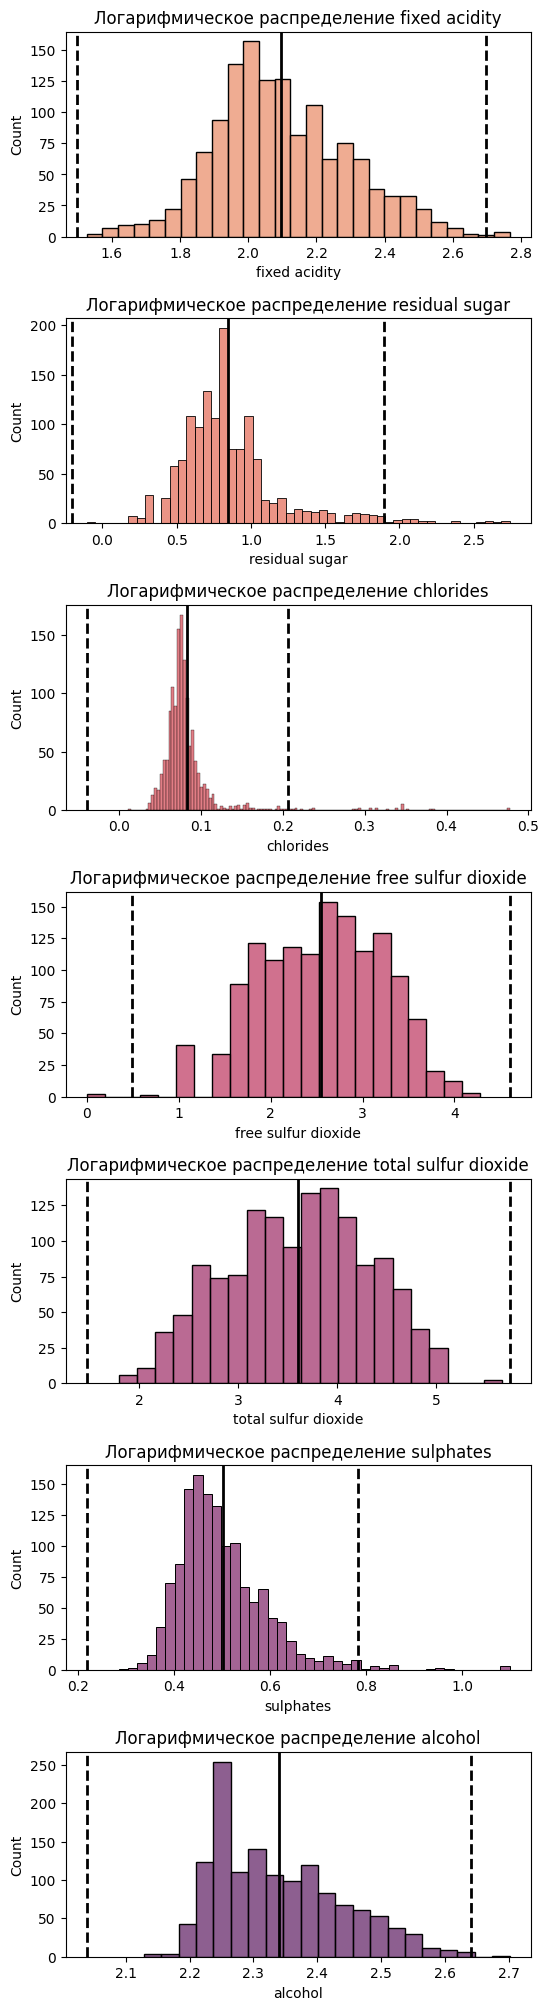

In [11]:
# Использование функции
colors = sns.color_palette('flare', n_colors=7)
fig, axes = plt.subplots(7, 1, figsize=(6, 25))
plt.subplots_adjust(hspace=0.4)

# Список столбцов и флаг, указывающий нужно ли добавлять 1
columns = [
    ('fixed acidity', False),
    ('residual sugar', False),
    ('chlorides', True),
    ('free sulfur dioxide', False),
    ('total sulfur dioxide', False),
    ('sulphates', True),
    ('alcohol', False)
]

# Построение графиков
for i, (column, add_one) in enumerate(columns):
    plot_log_distribution(wine_df, column, axes[i], colors[i], add_one)

После преобразования:
- **Распределение fixed acidity** имеет вид нормального немного право-скошенного, выбросы почти отсутствуют
- **Распределение residual sugar** имеет вид нормального право-скошенного, с большим количеством выбросов
- **Распределение chlorides** также имеет вид нормального право-скошенного, с большим количеством выбросов
- **Распределения free sulfur dioxide и total sulfur dioxide** имеют вид номральных распределений, без выбросов
- **Распределение sulphates** имеет вид нормального право-скошенного, с большим количеством выбросов

> Для устранения выбросов будем использовать использовать метод z-отклонений

In [12]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    """
    Определяет выбросы в данных и возвращает два набора по методу z-отклонений: 
    выбросы и очищенные данные.
    
    :param data: DataFrame, из которого необходимо удалить выбросы.
    :param feature: Имя столбца DataFrame, по которому определяются выбросы.
    :param log_scale: Если True, применяется логарифмическое преобразование к данным.
    :param left: Количество стандартных отклонений для нижней границы.
    :param right: Количество стандартных отклонений для верхней границы.
    :return: Два набора формата DataFrame, 
             первый с выбросами, второй с данными без выбросов.
    """
    
    # Применение логарифмического масштаба, если это указано
    if log_scale:
        # Применяем логарифмическое преобразование с добавлением 
        # 1, чтобы избежать логарифмирования нуля
        x = np.log(data[feature] + 1)
    else:
        # Используем данные без преобразований
        x = data[feature]
    
    # Рассчитываем среднее значение и стандартное отклонение
    mu = x.mean()
    sigma = x.std()
    
    # Определяем нижнюю и верхнюю границы для определения выбросов
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    
    # Определяем выбросы как те данные, которые выходят за пределы рассчитанных границ
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    
    # Очищенные данные — это те, которые находятся внутри границ
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]

    return outliers, cleaned

In [13]:
# Создаем список кортежей с названиями столбцов и флагом логарифмирования
features = [
    ('fixed acidity', True),
    ('volatile acidity', False),
    ('citric acid', False),
    ('residual sugar', True),
    ('chlorides', True),
    ('free sulfur dioxide', True),
    ('total sulfur dioxide', True),
    ('density', False),
    ('pH', False),
    ('sulphates', True),
    ('alcohol', True)
]

# Проходим по списку и выполняем функцию поиска выбросов для каждого столбца
for feature, log_scale in features:
    outliers, cleaned_data = outliers_z_score_mod(wine_df, feature, log_scale=log_scale)
    print(f'Число выбросов для {feature}: {outliers.shape[0]}')

    # Обновляем DataFrame только для очищенных данных
    wine_df = cleaned_data

print(' ')

# Выводим результирующее число записей после удаления всех выбросов
print(f'Результирующее число записей: {wine_df.shape[0]}')

Число выбросов для fixed acidity: 5
Число выбросов для volatile acidity: 9
Число выбросов для citric acid: 1
Число выбросов для residual sugar: 28
Число выбросов для chlorides: 29
Число выбросов для free sulfur dioxide: 2
Число выбросов для total sulfur dioxide: 0
Число выбросов для density: 7
Число выбросов для pH: 8
Число выбросов для sulphates: 16
Число выбросов для alcohol: 4
 
Результирующее число записей: 1250


> Построим распределения признаков после преобразований и удалений выбросов

In [14]:
def plot_hist_with_lines(df, column, ax, color, log_scale=False):
    """
    Построение гистограммы для заданного столбца данных с линиями среднего и стандартных отклонений.
    
    :param df: DataFrame, содержащий данные.
    :param column: Название столбца данных для построения гистограммы.
    :param ax: Ось, на которой будет построена гистограмма.
    :param color: Цвет для гистограммы.
    :param log_scale: Нужно ли применять логарифмическое преобразование к данным.
    """
    if log_scale:
        # Применяем логарифмическое преобразование, если требуется
        data_to_plot = np.log(df[column] + 1)
    else:
        data_to_plot = df[column]
        
    # Построение гистограммы
    sns.histplot(data_to_plot, ax=ax, color=color)
    
    # Расчет среднего и стандартного отклонения
    mean = data_to_plot.mean()
    std = data_to_plot.std()
    
    # Добавление линий среднего и +/- 3 стандартных отклонений
    ax.axvline(mean, color='k', lw=2)
    ax.axvline(mean + 3 * std, color='k', ls='--', lw=2)
    ax.axvline(mean - 3 * std, color='k', ls='--', lw=2)
    
    # Установка заголовка графика
    title = 'Логарифмическое распределение ' if log_scale else 'Распределение '
    ax.set_title(title + column)

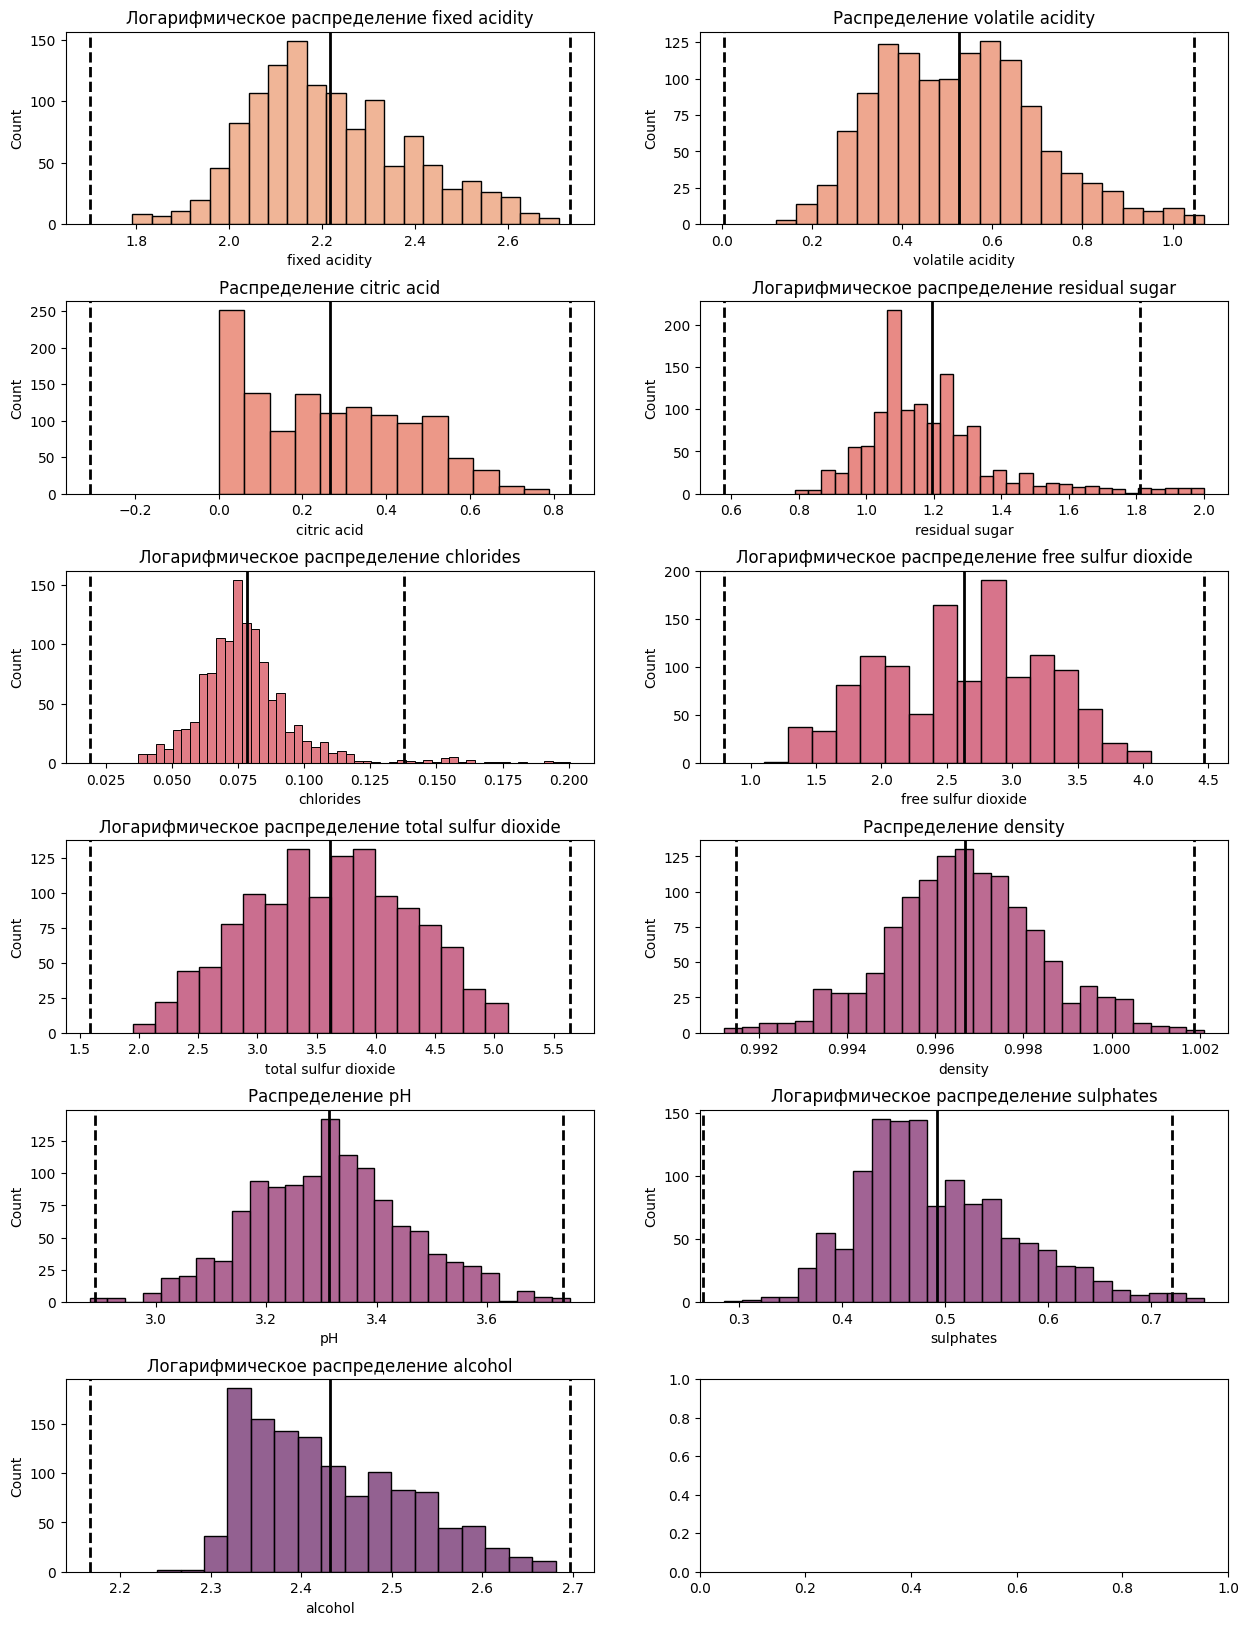

In [15]:
# Создание общей фигуры для всех графиков
colors = sns.color_palette('flare', n_colors=12)  # палитра цветов
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4)

# Список столбцов для построения гистограмм и флаг логарифмирования
columns_to_plot = [
    ('fixed acidity', True),
    ('volatile acidity', False),
    ('citric acid', False),
    ('residual sugar', True),
    ('chlorides', True),
    ('free sulfur dioxide', True),
    ('total sulfur dioxide', True),
    ('density', False),
    ('pH', False),
    ('sulphates', True),
    ('alcohol', True)
]

# Построение гистограмм для каждого столбца
for i, (column, log_scale) in enumerate(columns_to_plot):
    row = i // 2  # Определение номера строки для графика
    col = i % 2   # Определение номера столбца для графика
    plot_hist_with_lines(wine_df, column, axes[row][col], colors[i], log_scale)

plt.show() # Отображаем графики

In [16]:
# Выделяем целевую переменную и удаляем ее из основного датасета
y = wine_df['quality'] #берём таргет
x = wine_df.drop(columns='quality')

# разбиваем на обучающую и валидационные выборки
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) 

print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер обучающей выборки: (875, 11)
Размер тестовой выборки: (375, 11)


> В данном пункте был произведен первичный анализ данных, были удалены дубликаты и выбросы. Выборка разбита не тестовую и обучающую выборки.

## Обучение модели регрессии

Постройте модель регрессии, используя 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Для начала используйте гиперпараметры по умолчанию.

Рассчитайте среднее качество кросс-валидации модели как долю дисперсии зависимой переменной (коэффициент детерминации) $R^2$. Каким получилось качество? Какой алгоритм вы бы выбрали для дальнейшей работы? Обоснуйте свой выбор.

In [17]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import time

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly
import plotly.express as px

In [18]:
# Создаем экземпляр DesicionTree
dtr = DecisionTreeRegressor(random_state=42)

dtr.fit(X_train, y_train) # обучение
y_pred = dtr.predict(X_train) # предсказания

# Вычисление R2
print('R-squared DecisionTree:', r2_score(y_train, y_pred))

R-squared DecisionTree: 1.0


In [19]:
# Создаем экземпляр AdaBoost
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_train, y_train) # обучение
y_pred = abr.predict(X_train) # предсказания

# Вычисление R2
print('R-squared AdaBoost:', r2_score(y_train, y_pred))

R-squared AdaBoost: 0.4694394364125467


> В модели DecisionTree R2 равна 1, что может говорить о сильной переобучаемости модели, т.е. модель подстроилась под обучающие данные, можно ожидать низкое качество предсказаний на тестовой выборке. 

> В модели AdaBoost R2 равна примерно 0.47, что говорит о не очень высоком качестве данной модели, но все же я бы остановила свой выбор на ней, поскольку ожидаю от нее лучших показателей на тестовой выборке, чем от DecisionTree.

Теперь сделаем подбор оптимальных гиперпараметров. Сделайте поиск по сетке с помощью кросс-валидации. Изменилось ли качество алгоритмов? Почему?

In [54]:
# гиперпараметы
parameters = {'max_depth':np.arange(1,21).tolist()[0::2],
              'min_samples_split':np.arange(2,11).tolist()[0::2],
              'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}

dtr_param = GridSearchCV(dtr, parameters)
dtr_param.fit(X_train, y_train) # обучение

y_pred_dtr = dtr_param.predict(X_train) # предсказания

print('Лучшие гиперпараметры DecisionTree', dtr_param.best_params_) # смотрим лучший вариант гиперпараметров
print('R-squared DecisionTree with GridSearch:', r2_score(y_train, y_pred_dtr)) # смотрим метрику r2

Лучшие гиперпараметры DecisionTree {'max_depth': 3, 'max_leaf_nodes': 7, 'min_samples_split': 2}
R-squared DecisionTree with GridSearch: 0.34363862223438335


In [55]:
# гиперпараметы
parameters = {'n_estimators':list(range(2, 102, 2)), 
              'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

abr_param = GridSearchCV(abr, parameters)
abr_param.fit(X_train, y_train) # обучение
y_pred_abr = abr_param.predict(X_train) # предсказания

print('Лучшие гиперпараметры AdaBoost', abr_param.best_params_) # смотрим лучший вариант гиперпараметров
print('R-squared AdaBoost with GridSearch:', r2_score(y_train, y_pred_abr)) # смотрим метрику r2

Лучшие гиперпараметры AdaBoost {'learning_rate': 0.7, 'n_estimators': 86}
R-squared AdaBoost with GridSearch: 0.4909203028001161


> Качество алгоритма DecisionTree изменилось в худшую сторону, а в случае AdaBoost в лучшую сторону. Предполагаю, что это связано с настройкой параметра max_depth макисмальная губина дерева, дерево меньше подстраивается под обучающий набор

Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

In [33]:
# Создаем DataFrame для хранения данных о времени
time_df = pd.DataFrame({
    'DecisionTree': [],
    'AdaBoost' : []
})

# Задаем 100 итераций
for i in range(100):
    
    start_time = time.time() # Начало отсчета для DecisionTree
    dtr_param.fit(X_train, y_train)
    dtr_time = time.time() - start_time # Конец отсчета для DecisionTree
    
    start_time = time.time() # Начало отсчета для AdaBoost
    dtr_param.fit(X_train, y_train)
    abr_time = time.time() - start_time # Конец отсчета для AdaBoost
    
    # Записываем время в DataFrame
    time_df.loc[len(time_df.index)] = [dtr_time, abr_time]

In [62]:
fig = go.Figure()

# Ящики с усами при помощи библиотеки plotly
fig.add_trace(go.Box(x=time_df['DecisionTree'], name='DecisionTree'))
fig.add_trace(go.Box(x=time_df['AdaBoost'], name='AdaBoost'))
fig.update_layout(title='Время обучение моделей')

fig.show()

> Медианное значение времени обучения у алгоритма DecisionTree меньше, чем у AdaBoost (19.06 и 19.3 секунды). По данным графикам можно сделать вывод, что алгоритм DecisionTree быстрее.

> Для ускорения работы AdaBoost можно уменьшить n_estimators количество деревьев в лесу, также можно увеличить значение learning_rate.

> Для ускорения DecisionTree можно уменьшить максимальну глубину дерева max_depth, и уменьшить max_leaf_nodes.

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

> Для поиска оптимального количества компонент воспользуемся методом локтя.

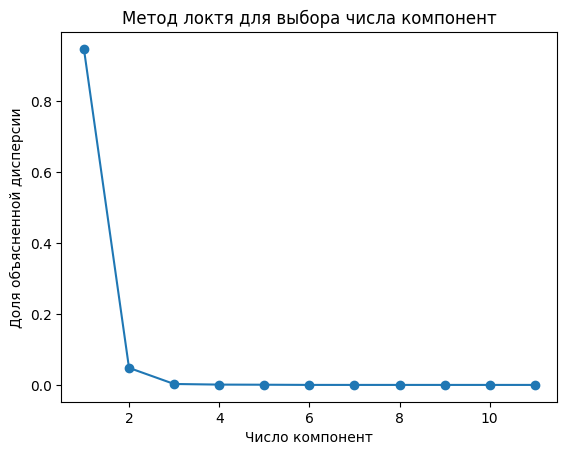

In [25]:
# Создаем экземпляр PCA
pca = PCA()

# Обучаем PCA
pca.fit(X_train)

# Строим график объясненной дисперсии
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

> Из графика следует, что оптимальное количество компонент = 3

In [61]:
# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Применение PCA для сокращения размерности
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_scaled)

# строим график
fig = px.scatter_3d(
    data_frame = X_reduced, # DataFrame
    x = X_reduced[:, 0], # ось абсцисс
    y = X_reduced[:, 1], # ось ординат
    z = X_reduced[:, 2], # ось аппликат
    color = y_train, # расцветка 
    width = 800,
    height = 700,
    title = 'Отображение датасета в 3D'
)

# отображаем график
fig.show()

## Обучение моделей на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Какой алгоритм справился лучше? Какой быстрее? Почему?

In [59]:
# гиперпараметы
parameters = {'max_depth':np.arange(1,21).tolist()[0::2],
              'min_samples_split':np.arange(2,11).tolist()[0::2],
              'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}

dtr_pca_param = GridSearchCV(DecisionTreeRegressor(random_state=42), parameters)
dtr_pca_param.fit(X_reduced, y_train) # обучение

y_pred_dtr_pca = dtr_pca_param.predict(X_reduced) # предсказания

print('Лучшие гиперпараметры DecisionTree', dtr_pca_param.best_params_) # смотрим лучший вариант гиперпараметров
print('R-squared DecisionTree with PCA:', r2_score(y_train, y_pred_dtr_pca)) # смотрим метрику r2

Лучшие гиперпараметры DecisionTree {'max_depth': 5, 'max_leaf_nodes': 9, 'min_samples_split': 2}
R-squared DecisionTree with PCA: 0.3613400061386114


In [60]:
# гиперпараметы
parameters = {'n_estimators':list(range(2, 102, 2)), 
              'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

abr_pca_param = GridSearchCV(AdaBoostRegressor(random_state=42), parameters)
abr_pca_param.fit(X_reduced, y_train) # обучение
y_pred_abr_pca = abr_pca_param.predict(X_reduced) # предсказания

print('Лучшие гиперпараметры AdaBoost', abr_pca_param.best_params_)  # смотрим лучший вариант гиперпараметров
print('R-squared AdaBoost with PCA:', r2_score(y_train, y_pred_abr_pca)) # смотрим метрику r2

Лучшие гиперпараметры AdaBoost {'learning_rate': 0.7, 'n_estimators': 14}
R-squared AdaBoost with PCA: 0.370472956521154


> Качество алгоритма AdaBoost в данном случае также немного выше, чем у DecisionTree, однако показатели ухудшились по сравнению с обучением на данных не трансформированных при помощи PCA, это связано с тем, что мы потеряли долю информативности в данных, когда уменьшили их размерность.

In [37]:
# DataFrame для фиксации значений времени обучения
time_pca_df = pd.DataFrame({
    'DecisionTree': [],
    'AdaBoost' : []
})

# задаем 100 итераций
for i in range(100):
    
    # фиксация времени обучения алгоритма DecisionTree
    start_time = time.time()
    dtr_pca_param.fit(X_train, y_train)
    dtr_time = time.time() - start_time
    
    # фиксация времени обучения алгоритма AdaBoost
    start_time = time.time()
    dtr_pca_param.fit(X_train, y_train)
    abr_time = time.time() - start_time
    
    # Внесение времен в DataFrame
    time_pca_df.loc[len(time_pca_df.index)] = [dtr_time, abr_time]

In [63]:
fig = go.Figure()

# Ящики с усами при помощи библиотеки plotly
fig.add_trace(go.Box(x=time_pca_df['DecisionTree'], name='DecisionTree'))
fig.add_trace(go.Box(x=time_pca_df['AdaBoost'], name='AdaBoost'))
fig.update_layout(title='Время обучения моделей с PCA')

fig.show()

> По данному графику видно, что медианное значение времени обучения алгоритма DecisionTree меньше чем у AdaBoost, как и в случае обучения на нетрансформированных данных. Значения 25 и 75 квантилей у алгоритма DecisionTree также меньше, однако максимальное значение у DecisionTree больше. Но все же я склоняюсь к тому, что алгоритм DecisionTree быстрее.

## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о моделях регрессии с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [69]:
# Качество моделей
ae_df = pd.DataFrame({
    'DecisionTree' : list(y_train - y_pred_dtr),
    'AdaBoost' : list(y_train - y_pred_abr),
    'DecisionTreePCA' : list(y_train - y_pred_dtr_pca),
    'AdaBoostPCA' : list(y_train - y_pred_abr_pca)
})
# Ящики с усами при помощи библиотеки plotly
fig = go.Figure()

fig.add_trace(go.Box(x=ae_df['DecisionTree'], name='DecisionTree'))
fig.add_trace(go.Box(x=ae_df['DecisionTreePCA'], name='DecisionTreePCA'))
fig.add_trace(go.Box(x=ae_df['AdaBoost'], name='AdaBoost'))
fig.add_trace(go.Box(x=ae_df['AdaBoostPCA'], name='AdaBoostPCA'))
fig.update_layout(title='Абсолютная ошибка предсказания моделей')

fig.show()

In [70]:
ae_df.describe()

,DecisionTree,AdaBoost,DecisionTreePCA,AdaBoostPCA
count,8.750000e+02,875.000000,8.750000e+02,875.000000
mean,8.729525e-17,-0.034454,4.669281e-17,-0.031883
std,6.586468e-01,0.579036,6.497046e-01,0.644253
min,-2.621891e+00,-1.308094,-2.172524e+00,-2.138554
25%,-2.368421e-01,-0.390909,-2.352941e-01,-0.397351
50%,-1.643357e-01,-0.146572,-1.725240e-01,-0.181435
75%,3.781095e-01,0.437008,4.716981e-01,0.349776
max,2.378109e+00,1.300562,2.022727e+00,1.748466


> Самое лучшее качество показала модель AdaBoost без PCA, об этом говорят и метрики R2 вычисляемые по ходу, и распределения абсолютных ошибок, показанные на данном графике. 

> В целом можно сделать вывод, что снижение размерности при помощи PCA негативно сказывается на качестве моделей, ухудшения видны в обоих моделях. 

In [68]:
# Время работы
total_time_df = pd.DataFrame({
    'DecisionTree' : time_df['DecisionTree'],
    'AdaBoost' : time_df['AdaBoost'],
    'DecisionTreePCA' : time_pca_df['DecisionTree'],
    'AdaBoostPCA' : time_pca_df['AdaBoost']
})

# Ящики с усами при помощи библиотеки plotly
fig = go.Figure()

fig.add_trace(go.Box(x=total_time_df['DecisionTree'], name='DecisionTree'))
fig.add_trace(go.Box(x=total_time_df['DecisionTreePCA'], name='DecisionTreePCA'))
fig.add_trace(go.Box(x=total_time_df['AdaBoost'], name='AdaBoost'))
fig.add_trace(go.Box(x=total_time_df['AdaBoostPCA'], name='AdaBoostPCA'))
fig.update_layout(title='Время обучения моделей')

fig.show()

> Что касается времени обучения, также по графику можно сказать, что PCA негативно влияет на время обучения моделей, оно сильно возросло, но данная оценка возможно не очень релевантна

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 30%). Не забудьте про все необходимые преобразования.

In [73]:
# Предсказание DecisionTree без GridSearch
y_pred_dtr_test = dtr.predict(X_test)
print('R-squared DecisionTree:', r2_score(y_test, y_pred_dtr_test)) # смотрим метрику r2

# Предсказание AdaBoost без GridSearch
y_pred_abr_test = abr.predict(X_test)
print('R-squared AdaBoost:', r2_score(y_test, y_pred_abr_test)) # смотрим метрику r2

# Предсказание DecisionTree
y_pred_dtrgs_test = dtr_param.predict(X_test)
print('R-squared DecisionTree GS:', r2_score(y_test, y_pred_dtrgs_test)) # смотрим метрику r2

# Предсказание AdaBoost
y_pred_abrgs_test = abr_param.predict(X_test)
print('R-squared AdaBoost GS:', r2_score(y_test, y_pred_abrgs_test)) # смотрим метрику r2

# Стандартизируем данные X_tets
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Применение PCA для сокращения размерности X_test
pca = PCA(n_components=3)
X_test_reduced = pca.fit_transform(X_test_scaled)

# Предсказание DecisionTree с PCA 
y_pred_dtr_pca_test = dtr_pca_param.predict(X_test_reduced)
print('R-squared DecisionTree PCA:', r2_score(y_test, y_pred_dtr_pca_test)) # смотрим метрику r2

# Предсказание AdaBoost с PCA 
y_pred_abr_pca_test = abr_pca_param.predict(X_test_reduced)
print('R-squared AdaBoost PCA', r2_score(y_test, y_pred_abr_pca_test)) # смотрим метрику r2

R-squared DecisionTree: -0.3351569623550863
R-squared AdaBoost: 0.38746441436675993
R-squared DecisionTree GS: 0.2685427112034954
R-squared AdaBoost GS: 0.39022847934602534
R-squared DecisionTree PCA: 0.27075070860796147
R-squared AdaBoost PCA 0.33672845308465493


> На тестовой выборке AdaBoost без PCA в подбором параметров также показывает наилучший результат. DecisionTree без подбора параметром как и ожидалось переобучился на обучающей выборке и показал очень плохой результат на тестовой. Показатели моделей с PCA чуть лучше в случае DecisionTree и сильно хуже в случае AdaBoost.

In [74]:
# Качество моделей
ae_df = pd.DataFrame({
    'DecisionTree' : list(y_test - y_pred_dtr_test),
    'AdaBoost' : list(y_test - y_pred_abr_test),
    'DecisionTreeGS' : list(y_test - y_pred_dtrgs_test),
    'AdaBoostGS' : list(y_test - y_pred_abrgs_test),
    'DecisionTreePCA' : list(y_test - y_pred_dtr_pca_test),
    'AdaBoostPCA' : list(y_test - y_pred_abr_pca_test)
})
# Ящики с усами при помощи библиотеки plotly
fig = go.Figure()

fig.add_trace(go.Box(x=ae_df['DecisionTree'], name='DecisionTree'))
fig.add_trace(go.Box(x=ae_df['DecisionTreeGS'], name='DecisionTreeGS'))
fig.add_trace(go.Box(x=ae_df['DecisionTreePCA'], name='DecisionTreePCA'))
fig.add_trace(go.Box(x=ae_df['AdaBoost'], name='AdaBoost'))
fig.add_trace(go.Box(x=ae_df['AdaBoostGS'], name='AdaBoostGS'))
fig.add_trace(go.Box(x=ae_df['AdaBoostPCA'], name='AdaBoostPCA'))
fig.update_layout(title='Абсолютная ошибка предсказания моделей')

fig.show()